# MCMC integration test

Here, we'll test performance of the nGP model on sample data.

In [1]:
import numpy as np
import ngptools as ngp
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

np.random.seed(12355)  # set random seed

### Load data

In [2]:
data = np.loadtxt('data/blocks_sampled.csv', delimiter=',')
tobs = data[:, 0]
y = data[:, 1].reshape(-1, 1)
Nt = y.size

### Define some useful variables

In [3]:
delta = np.diff(np.concatenate([tobs, [1.1]]))
Np, Nm, Nr = 1, 3, 3
dims = Np, Nm, Nr

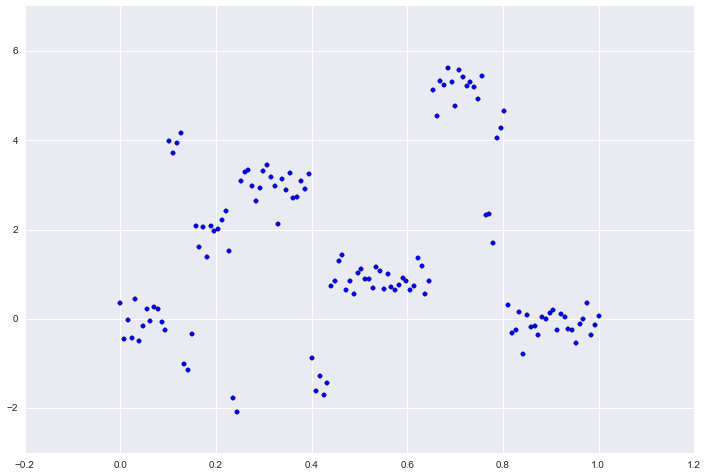

In [4]:
plt.figure(figsize=(12, 8))
plt.scatter(tobs, y)
pass

## Pick priors and starting values for parameters

In [5]:
sigU = 1e3
sigA = 5
sigeps = 2.
sigmu = 4.
sigalpha = 4.
a, b = 1., 1.

## Algorithm

The algorithm is as follows:

1. Given the various $\sigma^2$ parameters, perform an exact draw from the posterior for the state vector 
    $(U, DU, A)$.
1. Given the state vector, draw
    $$
    \sigma^2_\epsilon \sim \text{inv-Ga}\left( 
    a + \frac{N_t}{2},
    b + \frac{1}{2} \sum_t (y_t - U(t))^2
    \right)
    $$
1. Sample $\sigma^2_U$ and $\sigma^2_A$:

    1. Draw a sample of the state vector, $(U^*, DU^*, A^*)$, from the approximate model.
    1. Conditioned on this approximate state vector, sample proposed variance parameters as
        $$\begin{align}
        \sigma^2 &\sim \text{inv-Ga}\left(a + \frac{N_t}{2}, b + \frac{1}{2} R^2 \right) \\
        R^2_U &= \sum_j \delta_j \left[\frac{DU^*(t_{j+1}) - DU^*(t_j)}{\delta_j} - A^*(t_j) \right]^2 \\
        R^2_A &= \sum_j \left[\frac{(A^*(t_{j+1}) - A^*(t_j))^2}{\delta_j}\right]
        \end{align}$$
    1. Accept these proposals with probability $\mathrm{min}(\pi, 1)$ with
        $$
        \pi \equiv \prod_j \frac{\mathcal{N}(\theta_{j + 1} - G_j\theta_j|0, W^*_j)}
        {\mathcal{N}(\theta_{j + 1} - G_j\theta_j|0, W_j)}
        \frac{\mathcal{N}(\tilde{H}^\top (\theta^*_{j + 1} - \tilde{G}_j\theta^*_j)|0, \tilde{W}_j)}
        {\mathcal{N}(\tilde{H}^\top (\theta^*_{j + 1} - \tilde{G}_j\theta^*_j)|0, \tilde{W}^*_j)}
        $$
        (Think of this like $\frac{P(x')}{P(x)}\frac{g(x)}{g(x')}$, with $P$ the posterior and $g$ the proposal 
        distribution, and recall that what we are proposing is $\sigma^2|\theta^*$).

### Useful functions:

In [6]:
def draw_state(sigeps, sigU, sigA, approx=False):
    return ngp.sample(y, 1, dims, delta, sigeps, sigU, sigA, sigmu, sigalpha, approx)[0]

In [7]:
def draw_sig_eps(U):
    a_eff = a + (Nt / 2)
    b_eff = b + 0.5 * np.sum((y.ravel() - U)**2)
    return stats.invgamma.rvs(a=a_eff, scale=b_eff)

In [8]:
def calc_acceptance_prob(theta, theta_star, G, Gtilde, W, Wstar, Wtilde, Wtilde_star, Htilde):
    Nt = theta.shape[0]
    v = np.empty_like(theta)
    v_star = np.empty((theta.shape[0], Htilde.shape[-1]))
    
    for t in range(v.shape[0] - 1):
        v[t] = theta[t + 1] - G[t].dot(theta[t])
        v_star[t] = Htilde.T.dot(theta_star[t + 1] - Gtilde[t].dot(theta_star[t]))
    
    pi = 0
    for t in range(Nt):
        pi += stats.multivariate_normal.logpdf(x=v[t], mean=None, cov=Wstar[t])
        pi -= stats.multivariate_normal.logpdf(x=v[t], mean=None, cov=W[t])
        pi += stats.multivariate_normal.logpdf(x=v_star[t], mean=None, cov=Wtilde[t])
        pi -= stats.multivariate_normal.logpdf(x=v_star[t], mean=None, cov=Wtilde_star[t])
    
    return np.min([np.exp(pi), 1])

In [9]:
def draw_sigs(theta, sigeps, sigU, sigA):
    Nt = theta.shape[0]
    
    # draw state from approximate model
    theta_star = draw_state(sigeps, sigU, sigA, approx=True)
    
    Ustar = theta_star[:, 0]
    DUstar = theta_star[:, 1]
    Astar = theta_star[:, 2]
    
    # calculate sufficient statistics
    R2U = delta[:-1].dot(((np.diff(DUstar) / delta[:-1]) - Astar[:-1]) ** 2)
    R2A = np.sum(np.diff(Astar)**2 / delta[:-1])
    
    # draw proposals
    a_eff = a + (Nt / 2)
    sigU_star = np.sqrt(stats.invgamma.rvs(a=a_eff, scale=b + 0.5 * R2U))
    sigA_star = np.sqrt(stats.invgamma.rvs(a=a_eff, scale=b + 0.5 * R2A))
    
    assert(sigU_star > 0)
    assert(sigA_star > 0)
    
    _, _, G, H, W, _, _ = ngp._assemble_matrices(dims, delta, sigeps, sigU, 
                                                 sigA, sigmu, sigalpha, approx=False)
    _, _, Gtilde, Htilde, Wtilde, _, _ = ngp._assemble_matrices(dims, delta, sigeps, sigU, 
                                                 sigA, sigmu, sigalpha, approx=True)
    _, _, _, _, Wstar, _, _ = ngp._assemble_matrices(dims, delta, sigeps, sigU_star, 
                                                 sigA_star, sigmu, sigalpha, approx=False)
    _, _, _, _, Wtilde_star, _, _ = ngp._assemble_matrices(dims, delta, sigeps, sigU_star, 
                                                 sigA_star, sigmu, sigalpha, approx=True)
    
    # get acceptance probability
    acc_prob = calc_acceptance_prob(theta, theta_star, G, Gtilde, W, Wstar, Wtilde, Wtilde_star, Htilde)
    
    if np.random.rand() < acc_prob:
        return sigU_star, sigA_star
    else:
        return sigU, sigA

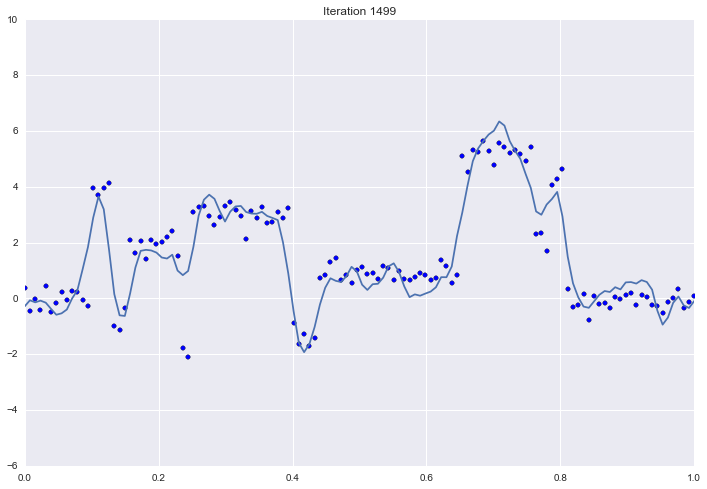

In [10]:
from IPython import display
plt.figure(figsize=(12, 8))

Niter = 1500
doplot = True

# initialize
th = np.empty((Niter + 1, Nt, Nm))
sig = np.empty((Niter + 1, 3))
sig[0] = sigeps, sigU, sigA
th[0] = np.nan

# draw samples
for idx in range(Niter):
    theta = draw_state(sigeps, sigU, sigA)
    sigeps = draw_sig_eps(theta[:, 0])
    sigU, sigA = draw_sigs(theta, sigeps, sigU, sigA)
    
    th[idx + 1] = theta
    sig[idx + 1] = sigeps, sigU, sigA
    
    # update plot
    if doplot:
        display.display(plt.gcf())
        plt.clf()
        plt.scatter(tobs, y)
        plt.plot(tobs, theta[:, 0])
        plt.xlim(0, 1)
        plt.ylim(-6, 10)
        plt.title("Iteration {}".format(idx))
        display.clear_output(wait=True)

In [11]:
sigeps, sigU, sigA

(0.56922388085723108, 682.51774655248153, 1.4000901792591129)

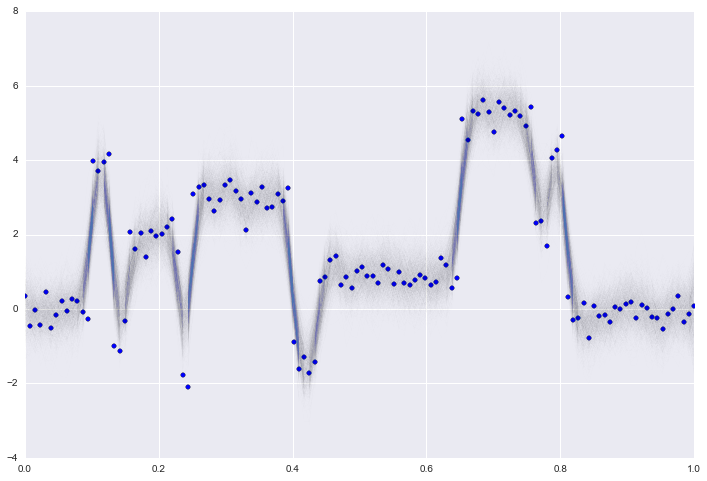

In [12]:
plt.figure(figsize=(12, 8))
trans = 5 / Niter

plt.plot(tobs, th[500:, :, 0].T, color=sns.color_palette()[0], alpha=trans)
plt.scatter(tobs, y)
plt.xlim(0, 1)
pass

In [13]:
th.shape

(1501, 128, 3)